In [40]:
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
data = pd.read_csv('../../../../data/NF-UNSW-NB15-v3/data/NF-UNSW-NB15-v3.csv')
# drop data with NaN or inf values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
data.reset_index(drop=True, inplace=True)

In [ ]:
data

,FLOW_START_MILLISECONDS,FLOW_END_MILLISECONDS,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,...,SRC_TO_DST_IAT_MIN,SRC_TO_DST_IAT_MAX,SRC_TO_DST_IAT_AVG,SRC_TO_DST_IAT_STDDEV,DST_TO_SRC_IAT_MIN,DST_TO_SRC_IAT_MAX,DST_TO_SRC_IAT_AVG,DST_TO_SRC_IAT_STDDEV,Label,Attack
0,1424242193040,1424242193043,59.166.0.2,4894,149.171.126.3,53,17,5.0,146,2,...,0,0,0,0,0,0,0,0,0,Benign
1,1424242192744,1424242193079,59.166.0.4,52671,149.171.126.6,31992,6,11.0,4704,28,...,0,91,12,19,0,90,12,19,0,Benign
2,1424242190649,1424242193109,59.166.0.0,47290,149.171.126.9,6881,6,37.0,13662,238,...,0,1843,10,119,0,1843,5,88,0,Benign
3,1424242193145,1424242193146,59.166.0.8,43310,149.171.126.7,53,17,5.0,146,2,...,0,0,0,0,0,0,0,0,0,Benign
4,1424242193239,1424242193241,59.166.0.1,45870,149.171.126.1,53,17,5.0,130,2,...,0,0,0,0,0,0,0,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2242926,1421972723458,1421972723766,59.166.0.6,8647,149.171.126.8,25,6,37.0,31366,42,...,0,73,7,21,0,74,10,25,0,Benign
2242927,1421972723557,1421972723563,59.166.0.2,4681,149.171.126.1,5190,6,37.0,2054,22,...,0,1,0,0,0,1,0,0,0,Benign
2242928,1421972723565,1421972723788,59.166.0.2,47560,149.171.126.2,6125,6,37.0,8928,14,...,0,173,16,46,0,174,44,67,0,Benign
2242929,1421972723758,1421972723759,59.166.0.3,44991,149.171.126.5,53,17,5.0,146,2,...,0,0,0,0,0,0,0,0,0,Benign


In [ ]:
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [ ]:
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(str)
data['L4_SRC_PORT'] = data.L4_SRC_PORT.apply(str)
data['IPV4_DST_ADDR'] = data.IPV4_DST_ADDR.apply(str)
data['L4_DST_PORT'] = data.L4_DST_PORT.apply(str)

In [ ]:
data['IPV4_SRC_ADDR'] = data['IPV4_SRC_ADDR'] + ':' + data['L4_SRC_PORT']
data['IPV4_DST_ADDR'] = data['IPV4_DST_ADDR'] + ':' + data['L4_DST_PORT']

In [ ]:
data.drop(columns=['FLOW_START_MILLISECONDS','FLOW_END_MILLISECONDS','L4_SRC_PORT','L4_DST_PORT'],inplace=True)

In [ ]:
data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2242931 entries, 0 to 2242930
Data columns (total 51 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   IPV4_SRC_ADDR                object 
 1   IPV4_DST_ADDR                object 
 2   PROTOCOL                     int64  
 3   L7_PROTO                     float64
 4   IN_BYTES                     int64  
 5   IN_PKTS                      int64  
 6   OUT_BYTES                    int64  
 7   OUT_PKTS                     int64  
 8   TCP_FLAGS                    int64  
 9   CLIENT_TCP_FLAGS             int64  
 10  SERVER_TCP_FLAGS             int64  
 11  FLOW_DURATION_MILLISECONDS   int64  
 12  DURATION_IN                  int64  
 13  DURATION_OUT                 int64  
 14  MIN_TTL                      int64  
 15  MAX_TTL                      int64  
 16  LONGEST_FLOW_PKT             int64  
 17  SHORTEST_FLOW_PKT            int64  
 18  MIN_IP_PKT_LEN               int64  
 19  

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,SRC_TO_DST_IAT_MIN,SRC_TO_DST_IAT_MAX,SRC_TO_DST_IAT_AVG,SRC_TO_DST_IAT_STDDEV,DST_TO_SRC_IAT_MIN,DST_TO_SRC_IAT_MAX,DST_TO_SRC_IAT_AVG,DST_TO_SRC_IAT_STDDEV,Label,Attack
0,172.26.123.138:4894,149.171.126.3:53,17,5.0,146,2,178,2,0,0,...,0,0,0,0,0,0,0,0,0,Benign
1,172.19.213.96:52671,149.171.126.6:31992,6,11.0,4704,28,2976,28,27,27,...,0,91,12,19,0,90,12,19,0,Benign
2,172.30.218.174:47290,149.171.126.9:6881,6,37.0,13662,238,548216,438,27,27,...,0,1843,10,119,0,1843,5,88,0,Benign
3,172.30.191.217:43310,149.171.126.7:53,17,5.0,146,2,178,2,0,0,...,0,0,0,0,0,0,0,0,0,Benign
4,172.28.41.89:45870,149.171.126.1:53,17,5.0,130,2,162,2,0,0,...,0,0,0,0,0,0,0,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2242926,172.26.121.155:8647,149.171.126.8:25,6,37.0,31366,42,2566,30,26,26,...,0,73,7,21,0,74,10,25,0,Benign
2242927,172.18.54.102:4681,149.171.126.1:5190,6,37.0,2054,22,2478,24,27,27,...,0,1,0,0,0,1,0,0,0,Benign
2242928,172.28.48.183:47560,149.171.126.2:6125,6,37.0,8928,14,320,6,27,27,...,0,173,16,46,0,174,44,67,0,Benign
2242929,172.22.148.171:44991,149.171.126.5:53,17,5.0,146,2,178,2,0,0,...,0,0,0,0,0,0,0,0,0,Benign


In [ ]:
data.drop(columns=['Label'],inplace = True)

In [ ]:
data.rename(columns={"Attack": "label"},inplace = True)

In [ ]:
le = LabelEncoder()
le.fit_transform(data.label.values)
data['label'] = le.transform(data['label'])

In [ ]:
label = data.label

In [ ]:
data.drop(columns=['label'],inplace = True)

In [ ]:
scaler = StandardScaler()

In [ ]:
data =  pd.concat([data, label], axis=1)

In [ ]:
data

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,FTP_COMMAND_RET_CODE,SRC_TO_DST_IAT_MIN,SRC_TO_DST_IAT_MAX,SRC_TO_DST_IAT_AVG,SRC_TO_DST_IAT_STDDEV,DST_TO_SRC_IAT_MIN,DST_TO_SRC_IAT_MAX,DST_TO_SRC_IAT_AVG,DST_TO_SRC_IAT_STDDEV,label
0,172.26.123.138:4894,149.171.126.3:53,17,5.0,146,2,178,2,0,0,...,0,0,0,0,0,0,0,0,0,2
1,172.19.213.96:52671,149.171.126.6:31992,6,11.0,4704,28,2976,28,27,27,...,0,0,91,12,19,0,90,12,19,2
2,172.30.218.174:47290,149.171.126.9:6881,6,37.0,13662,238,548216,438,27,27,...,0,0,1843,10,119,0,1843,5,88,2
3,172.30.191.217:43310,149.171.126.7:53,17,5.0,146,2,178,2,0,0,...,0,0,0,0,0,0,0,0,0,2
4,172.28.41.89:45870,149.171.126.1:53,17,5.0,130,2,162,2,0,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2242926,172.26.121.155:8647,149.171.126.8:25,6,37.0,31366,42,2566,30,26,26,...,0,0,73,7,21,0,74,10,25,2
2242927,172.18.54.102:4681,149.171.126.1:5190,6,37.0,2054,22,2478,24,27,27,...,0,0,1,0,0,0,1,0,0,2
2242928,172.28.48.183:47560,149.171.126.2:6125,6,37.0,8928,14,320,6,27,27,...,0,0,173,16,46,0,174,44,67,2
2242929,172.22.148.171:44991,149.171.126.5:53,17,5.0,146,2,178,2,0,0,...,0,0,0,0,0,0,0,0,0,2


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
     data, label, test_size=0.3, random_state=123,stratify= label)

In [ ]:
encoder = ce.TargetEncoder(cols=['TCP_FLAGS','L7_PROTO','PROTOCOL'])
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)

In [ ]:
# normalize all columns except the first four and the label column
cols_to_norm = list(set(list(X_train.iloc[:, 4:].columns ))  - set(list(['label'])) )
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])

In [ ]:
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

In [ ]:
X_train

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,SRC_TO_DST_IAT_MIN,SRC_TO_DST_IAT_MAX,SRC_TO_DST_IAT_AVG,SRC_TO_DST_IAT_STDDEV,DST_TO_SRC_IAT_MIN,DST_TO_SRC_IAT_MAX,DST_TO_SRC_IAT_AVG,DST_TO_SRC_IAT_STDDEV,label,h
130871,172.17.149.156:5048,149.171.126.6:80,2.131838,2.287952,-0.041869,-0.287140,-0.164749,-0.246007,-0.160825,0.624886,...,-0.023566,0.861543,0.184147,1.048041,-0.003581,1.003007,0.644914,1.471645,2,"[0.6325361530802263, -0.1573327971957286, -0.4..."
603665,172.22.67.201:5934,149.171.126.3:25,2.131838,2.000010,0.464867,0.185641,-0.207751,-0.042842,-0.160825,0.624886,...,-0.023566,0.143470,-0.010918,0.058295,-0.003581,0.176318,0.177252,0.189837,2,"[0.6325361530802263, -0.1573327971957286, 0.10..."
171853,172.29.118.128:46379,149.171.126.12:179,2.131838,4.787674,-0.057979,-0.336906,-0.227541,-0.347589,5.790334,-0.143282,...,-0.023566,-0.074536,0.050491,0.053491,-0.003581,0.052121,0.800801,0.450804,4,"[-0.13194195782085183, -0.1573327971957286, -0..."
927972,172.25.197.84:62630,149.171.126.2:111,2.003698,2.090137,-0.057779,-0.411556,-0.227187,-0.364520,-0.209259,-1.967683,...,-0.023566,0.051323,0.238332,0.399421,-0.003581,0.044359,1.065810,0.604314,2,"[-1.9475774712109122, -0.1573327971957286, -0...."
343809,172.27.166.221:15665,149.171.126.5:21,2.131838,2.000010,-0.055883,-0.299581,-0.222486,-0.271402,-0.165365,0.336823,...,-0.023566,-0.259954,-0.094002,-0.229980,-0.003581,-0.289421,-0.274821,-0.332097,2,"[0.345856861492322, -0.1573327971957286, -0.23..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951689,172.25.6.213:36461,149.171.126.3:21,2.131838,2.000010,-0.059019,-0.349348,-0.224412,-0.305263,-0.165365,0.336823,...,-0.023566,-0.030710,0.010755,0.039077,-0.003581,-0.024209,0.224018,0.097731,2,"[0.345856861492322, -0.1573327971957286, -0.33..."
582421,172.16.94.215:28508,149.171.126.8:24786,2.131838,2.000000,-0.034085,-0.038308,-0.135304,-0.093633,-0.160825,0.624886,...,-0.023566,-0.258830,-0.094002,-0.229980,-0.003581,-0.288128,-0.274821,-0.332097,2,"[0.6325361530802263, -0.1573327971957286, 0.03..."
1851732,172.21.243.97:21486,149.171.126.6:143,2.131838,2.132666,0.045667,1.056554,-0.132010,0.668234,-0.160825,0.624886,...,-0.023566,-0.216128,-0.090390,-0.210762,-0.003581,-0.237673,-0.259232,-0.301395,2,"[0.6325361530802263, -0.1573327971957286, 2.08..."
320821,172.17.7.170:36236,149.171.126.9:22,2.131838,2.004864,0.139532,0.757955,-0.119961,0.465069,-0.160825,0.624886,...,-0.023566,-0.221747,-0.094002,-0.210762,-0.003581,-0.244141,-0.274821,-0.309070,2,"[0.6325361530802263, -0.1573327971957286, 1.27..."


In [ ]:
G = nx.from_pandas_edgelist(X_train, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())

In [ ]:
G = G.to_directed()


In [ ]:
G = from_networkx(G,edge_attrs=['h','label'] )


In [ ]:
# Eq1
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [ ]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)


In [ ]:
G.edata['train_mask'] 

tensor([True, True, True,  ..., True, True, True])

In [ ]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [ ]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5          
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

In [ ]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [ ]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))

In [ ]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout, num_classes):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, num_classes)
    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(G.edata['label'].cpu().numpy()),
                                                 y=G.edata['label'].cpu().numpy())

In [ ]:
#class_weights = th.FloatTensor(class_weights).cuda()  - if you have a nvidia GPU
class_weights = th.FloatTensor(class_weights)
criterion = nn.CrossEntropyLoss(weight = class_weights)

In [ ]:
# uncomment if you have a NVIDIA GPU
# G = G.to('cuda:0')
G.device

device(type='cpu')

In [ ]:
G.ndata['h'].device


device(type='cpu')

In [ ]:
G.edata['h'].device


device(type='cpu')

In [ ]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']
num_classes = len(np.unique(G.edata['label'].cpu().numpy()))

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2, num_classes) #.cuda()
opt = th.optim.Adam(model.parameters())

for epoch in range(1,50): # original 8000, maybe too much and will cause out of memory error
    pred = model(G, node_features,edge_features) #.cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
      print('Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))


RuntimeError: weight tensor should be defined either for all 5 classes or no classes but got weight tensor of shape: [10]

In [ ]:
X_test = encoder.transform(X_test)

In [ ]:
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

In [ ]:
X_test

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
508964,172.29.164.251:3851,192.168.100.148:57874,0.256954,0.564662,-0.017440,-0.008374,-0.045641,-0.024336,0.675890,0.496292,3
550351,172.27.194.211:59388,192.168.100.3:80,0.256954,-1.663308,-0.015694,-0.007551,-0.021496,-0.003471,-1.557296,-2.082482,3
126326,172.30.164.19:14903,192.168.100.3:12625,0.256954,0.564662,-0.017440,-0.008378,-0.045641,-0.024336,0.675890,0.496292,3
75198,172.23.94.131:33223,192.168.100.5:2383,0.256954,0.564662,-0.017433,-0.008378,-0.045641,-0.024336,0.675890,0.496290,3
459608,172.22.61.164:53308,192.168.100.3:3306,0.256954,0.564662,-0.016705,-0.007860,-0.021496,0.001745,-1.378847,0.496174,3
...,...,...,...,...,...,...,...,...,...,...,...
219108,172.18.51.155:45576,192.168.100.3:1114,0.256954,0.564662,-0.017433,-0.008378,-0.045641,-0.024336,0.675890,0.496292,3
527997,172.22.242.126:40850,192.168.100.3:60161,0.256954,0.564662,-0.017433,-0.008378,-0.045641,-0.024336,0.675890,0.496292,3
38363,172.22.50.60:57088,192.168.100.7:80,0.256954,-1.663308,-0.016455,-0.006905,-0.029544,-0.008687,-1.378847,0.486699,1
159958,172.25.87.154:39747,192.168.100.7:2251,0.256954,0.564662,-0.017433,-0.008378,-0.045641,-0.024336,0.675890,0.496292,3


In [ ]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [ ]:
G_test = nx.from_pandas_edgelist(X_test, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G.ndata['h'].shape[2])

In [ ]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))

In [ ]:
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))


In [ ]:
# G_test = G_test.to('cuda:0')


In [ ]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test) #.cuda()
elapsed = timeit.default_timer() - start_time

In [ ]:
print(str(elapsed) + ' seconds')


0.02484787100001995 seconds


In [ ]:
test_pred = test_pred.argmax(1)


In [ ]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()


In [ ]:
actual = le.inverse_transform(actual)
test_pred = le.inverse_transform(test_pred)

In [ ]:
from sklearn.metrics import plot_confusion_matrix


In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

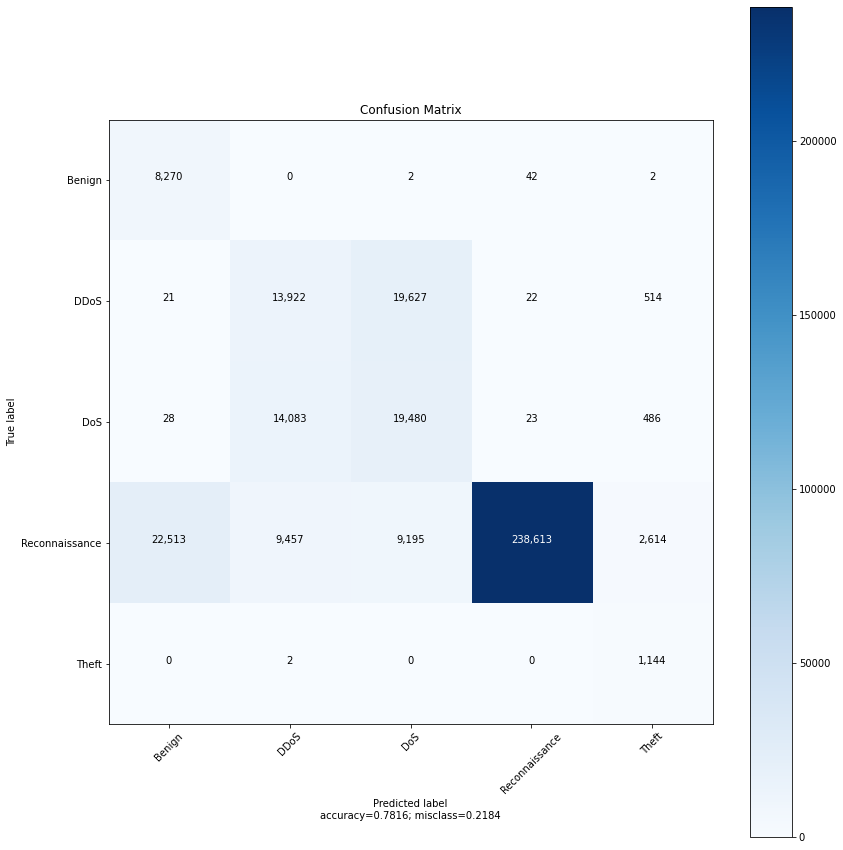

In [ ]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(actual, test_pred), 
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")